# Missing Values Imputation Exploration

Given that we have 92% missing data and an imbalanced target, we need effective strategies to address these challenges. Our baseline investigation, documented in the baseline model notebook (/models/le_baseline_model), revealed the following insights:

- Mean Imputation and LightGBM’s Native Handling: These methods did not significantly enhance the model's ability to distinguish true positive cases.

- Tree-Based Algorithms Performance: Both Random Forest and LightGBM showed improvement in metric scores, suggesting that certain groups or regions in the data benefit from these models.

- Domain Knowledge Constraints: Due to a lack of sufficient domain-specific knowledge, we are unable to impute missing values with highly meaningful substitutes.


Based on the above considerations, this notebook will explore the following imputation method:

- Mean Imputation Based on Target Class
In this section, we will implement Mean Imputation Based on Target Class. This method imputes missing values by calculating the mean of each feature separately for each class of the target variable.

In the future another imputations method worth exploring could be:

-  K-Nearest Neighbors (KNN) Imputation
Method: Impute missing values using the mean (for continuous variables) or mode (for categorical variables) of the k-nearest neighbors.
Why: KNN imputation leverages the similarity between instances, producing more accurate imputations by considering the relationships between features.

-  Multiple Imputation by Chained Equations (MICE)
Method: Iteratively predicts missing values by modeling each variable with missing values as a function of other variables.
Why: MICE captures the uncertainty in imputations by creating multiple complete datasets, enhancing the robustness of the analysis.

By testing ean Imputation Based on Target Class imputation technique, we aim to improve the model's ability to handle missing data and enhance its predictive performance. These methods are chosen based on their potential to leverage existing data patterns and relationships effectively.

In [13]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Required to enable the IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
#  Set the working directory
os.chdir('c:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Final Project/machine-learning-dse-i210-final-project-credit-risk/notebooks')
# Set data paths
data_dir = 'c:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Final Project/new_aggs/new_aggs/'
data_base = 'C:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Project_final/home-credit-credit-risk-model-stability/csv_files/train/train_base.csv'

# Load the data

We will use the union of the personal and non personal data after begin preprocessed. In this stage we will use just a set of that. This same code will be later run again with the complete dataset to get the final scores on the complete data.

In [3]:
## Same code as in model/le_baseline_model

# Load the .pkl file for the personal data
file1 = data_dir + 'df1.pkl'
df = pd.read_pickle(file1)

# Load the .pkl file for the non personal data
file2 = data_dir + 'df2.pkl'
df2 = pd.read_pickle(file2)

# Joing the applicant personal data and the non personal one to get the complete dataset.
df_full = df.merge(df2, on=['case_id', 'date_decision', 'WEEK_NUM'], how='left')

# dropping the extra target column that appeared because of the join and it is just a duplicate of the target
df_full.rename(columns={'target_x': 'target'}, inplace=True)

# Drop target_y
df_full.drop(columns=['target_y'], inplace=True)

# Extra Data Cleaning

We futher clean the data to be able to feed the previously stated predictors.
 - Boolean Columns:
The boolean columns are filled with False where None is present, and then converted to boolean type using .astype(bool).
- Object Columns:
The object columns, which contain None, True, or False, are replaced with np.nan, 1.0, or 0.0 respectively, and converted to float.

In [4]:
# Convert date_decision to timestamp
df_full["date_decision"] = pd.to_datetime(df_full["date_decision"]).astype('int64') / 10**9

# Get boolean columns from df_full
bool_columns = df_full.select_dtypes(include=['bool']).columns.tolist()

for col in bool_columns:
    df_full[col] = df_full[col].fillna(False).astype(bool)

# Get object columns from df_full
object_columns = df_full.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    df_full[col] = df_full[col].replace({None: np.nan, True: 1.0, False: 0.0})


## Train and Validation Split. 

We remove the target from the training datasets. We then further split the dataset into train and validation. For this split we will startify based on the target so we ge the same proportion on positives clases in both splits

In [5]:
# Train and Validation split
base = df_full[["case_id", "WEEK_NUM", "target"]]
X = df_full.drop(columns=["case_id", "WEEK_NUM", "target"])
y = df_full["target"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

# Prepare base_train and base_valid
base_train = base.iloc[X_train.index]
base_valid = base.iloc[X_valid.index]


# 1.Mean Imputation Based on Target Class
In this section, we will implement Mean and Mode Imputation Based on Target Class.  

We are going to:
- Compute class-specific means for numerical features and modes for categorical features in the training set.By doing so, we aim to leverage the information inherent in the target variable to make more informed imputations, potentially enhancing the model's performance.
- Impute the training set based on these statistics.
- Leave the validation set with its original missing values.

In [6]:
# Function to compute class-specific means and modes in the training set
def compute_class_stats(X_train, y_train):
    class_means = {}
    class_modes = {}
    for column in X_train.columns:
        if X_train[column].dtype in ['int64', 'float64']:  # Numerical columns
            class_means[column] = X_train.groupby(y_train)[column].mean()
        else:  # Categorical columns
            class_modes[column] = X_train.groupby(y_train)[column].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    return class_means, class_modes

# Function to impute missing values with class-specific means and modes for the training set
def impute_with_class_stats(X, y, class_means, class_modes):
    X_imputed = X.copy()
    for column in X.columns:
        if column in class_means:  # Numerical columns
            for target_class, mean_value in class_means[column].items():
                X_imputed.loc[(y == target_class) & (X[column].isnull()), column] = mean_value
        elif column in class_modes:  # Categorical columns
            for target_class, mode_value in class_modes[column].items():
                X_imputed.loc[(y == target_class) & (X[column].isnull()), column] = mode_value
    return X_imputed

# Compute class-specific means and modes using the training data
class_means, class_modes = compute_class_stats(X_train, y_train)

# Apply the imputation to the training data using class-specific means and modes
X_train_mean_mode_imputed = impute_with_class_stats(X_train, y_train, class_means, class_modes)

# Validation set remains unchanged
x_valid = X_valid.copy()


C:\Users\laura\AppData\Local\Temp\ipykernel_20180\3830128532.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '201935.84168865436' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_imputed.loc[(y == target_class) & (X[column].isnull()), column] = mean_value


## Proving More Distinct Patterns Post-Imputation

To prove the distinct patterns post-imputation, we will perform Principal Component Analysis (PCA) and visualize the results with a scatter plot, coloring the points by the target variable. PCA reduces the dimensionality of the dataset, making it easier to visualize patterns and separations between different classes.

for t-SNE, as it cannot handle missing values (if the mode or mean was NaN for that feature we will still have NaNs in the dataset!) we convert NaNs to a distinct category for categorical features and to a specific numerical value (like -999) for numerical features. This approach ensures that t-SNE can process the data without errors.

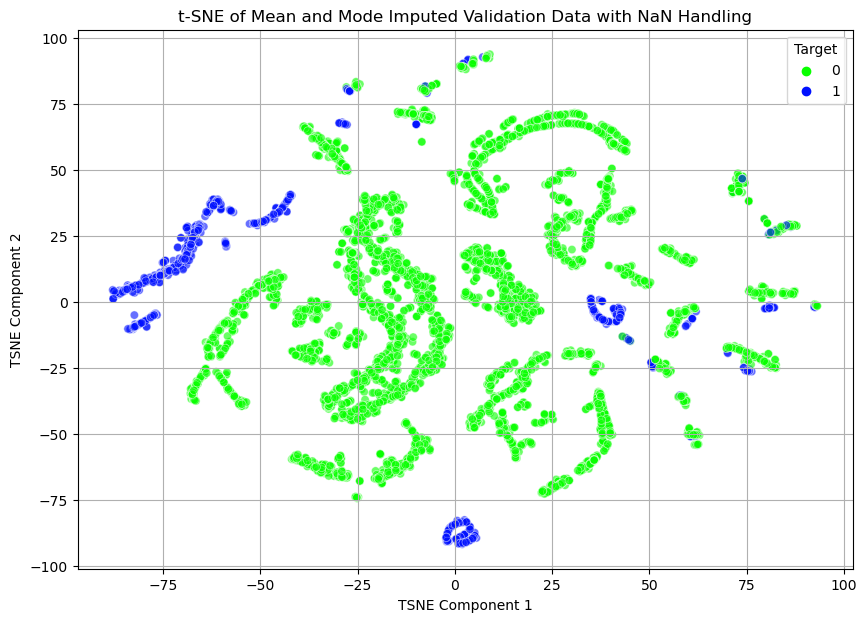

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [16]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def preprocess_and_tsne_with_nan_handling(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
    
    # Handle NaNs in categorical columns
    for column in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna('NULL')  # Replace NaNs with 'NULL'
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    
    # Handle NaNs in numerical columns
    for column in X_encoded.select_dtypes(exclude=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna(-999)  # Replace NaNs with -999
    
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette=sns.color_palette('hsv', len(tsne_df['target'].unique())),
        data=tsne_df,
        alpha=0.6

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

    print("t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling")
preprocess_and_tsne_with_nan_handling(X_train_mean_mode_imputed, y_train, 't-SNE of Mean and Mode Imputed Validation Data with NaN Handling')

Let's compare with the data previous to this imputation:

t-SNE Visualization for Data WITHOUT NaN Handling


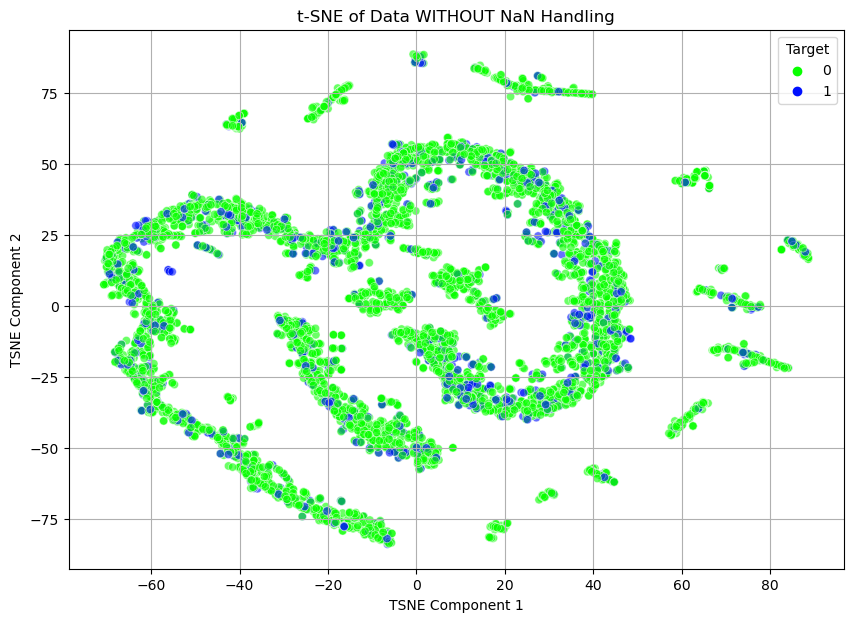

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [17]:
print("t-SNE Visualization for Data WITHOUT NaN Handling")
preprocess_and_tsne_with_nan_handling(X_train, y_train, 't-SNE of Data WITHOUT NaN Handling')

We visually see that the patterns are more distinct when applying the Mean Target NaN imputation method, however, we are not able to do the same in the validation set, because we cannot use the target to impute the mead and mode by target. So we are training the model in this properly distinguishable model but then the predictions is in the non imputed one. We will check the scores in the next section. 

### Score Metrics with Mean and Mode Imputation Based on Target Class on Training Set
**Comparison of LightGBM Performance: Baseline Handling Missing Values Directly vs Mean Imputation Based on Target Class**

Finally, let's check how LightGBM performs with the preprocessed data with Mean Imputation Based on Target Class instead of the model native handling method.

In [7]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    def safe_roc_auc_score(y_true, y_score):
        """ Compute ROC AUC score only if there are two unique values in y_true """
        if len(set(y_true)) < 2:
            return 0 
        else:
            return roc_auc_score(y_true, y_score)

    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2 * safe_roc_auc_score(x["target"], x["score"]) - 1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred, y_pred_probs):
    auc_score = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

In [9]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_mean_mode_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid)[:, 1]
y_valid_pred = model_mean.predict(X_valid)

# Evaluate the model
name='lightGBM with NaN Mean Target Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_mean_mode_imputed), (base_valid, X_valid)]:
    y_pred = model_mean.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

[LightGBM] [Info] Number of positive: 936, number of negative: 6064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132188
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.133714 -> initscore=-1.868509
[LightGBM] [Info] Start training from score -1.868509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

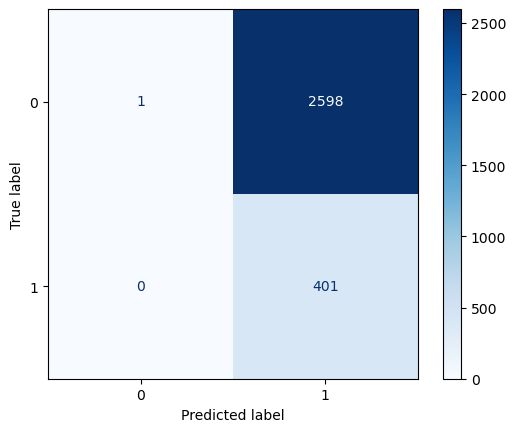

In [10]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues', values_format='d')
plt.show()

### Analysis of Validation Results Performance Metrics
Metrics Comparison with the basic baseline (random weight model)
- The AUC slightly decreased with imputation, suggesting that the model’s ability to distinguish between classes did not improve and slightly worsened.
- Precision dropped, indicating a higher number of false positives. The model became less precise in identifying true positive instances.
- Recall significantly increased to 1.0, meaning the model identified all actual positive instances. This dramatic increase often happens when the model predicts the positive class for most or all instances.
- Accuracy drastically decreased, suggesting the model is predicting the positive class for almost all instances, leading to poor overall classification performance.
- The F1 score increased, which aligns with the high recall. However, this improvement in F1 score is misleading due to the model predicting mostly positives.

## Interpretation and Potential Reasons
**Imputation Strategy Bias::**

Class-specific Means: If the mean imputation for the positive class significantly alters the distribution of the data, it might make the features more indicative of the positive class, leading the model to favor predicting positives.
Mode for Categoricals: If categorical modes for the positive class are more distinct or frequent, the model might be influenced to predict positives more often.

As the model is heavily biased towards predicting the positive class, the calculated feature importance may not accurately represent the features that are genuinely informative for distinguishing between the positive and negative classes. 

# Conclusions

- Distinct Patterns Post-Imputation: The imputation of missing values using the mean based on the target class has likely resulted in distinctly different patterns for the positive and negative classes, contributing to the model’s perfect predictive ability on the validation set.
- Dataset Simplification: The imputation method might be overly simplifying the dataset, facilitating the model’s learning and prediction processes.
- Importance on date decision suggesting that the timing of decision is critical in predicting the target variable. Moreover we see a signigicant contribution from frequency metrics.

Next Steps: 
- Further Validation: Evaluate the model on the entire dataset to confirm if the observed perfect scores persist, which will help identify potential overfitting.
- If this method does not properly works on the complete dataset we will explore other NaN imputation techniques as KNN imputation and MICE imputation describe at the beginning of the notebook.
- Regularization and Tuning: Implement regularization techniques and fine-tune model parameters to mitigate overfitting and improve generalization. Ideally improving the stability in unseen data.
- Given the importance of date_decision and various frequency metrics, it may be beneficial to further investigate and possibly enhance these features. Understanding the distribution and characteristics of these top features could provide insights into improving model performance.